In [1]:
# @title Setup for Google Colab
# Run this cell if you are using Google Colab to set up the environment.

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab. Setting up environment...")

    # 1. Clone the repository
    !git clone https://github.com/Boussyf0/MANTIS-Maintenance-Intelligence-System-.git mantis_repo

    # 2. Change working directory
    import os
    os.chdir('mantis_repo')

    # 3. Create data directories
    if not os.path.exists('data/raw/NASA_CMAPSS'):
        os.makedirs('data/raw/NASA_CMAPSS')

    # 4. Download and unzip dataset (Robust w/ mirrors)
    if not os.path.exists('data/raw/NASA_CMAPSS/train_FD001.txt'):
        print("Downloading NASA CMAPSS Data...")

        urls = [
            'https://data.nasa.gov/api/views/s96h-rxk2/files/8b8e05a8-6f16-43b6-96b6-81a171ef9948?download=true&filename=CMAPSSData.zip',
            'https://raw.githubusercontent.com/senthilnayagan/CMS_DeepLearning/master/CMAPSSData.zip',
            'https://data.nasa.gov/docs/legacy/CMAPSSData.zip'
        ]

        success = False
        for url in urls:
            print(f"Trying {url}...")
            try:
                exit_code = os.system(f'wget "{url}" -O data/raw/NASA_CMAPSS/CMAPSSData.zip')
                if exit_code == 0:
                    success = True
                    print("Download successful.")
                    break
            except Exception as e:
                print(f"Failed: {e}")

        if success:
            !unzip -o data/raw/NASA_CMAPSS/CMAPSSData.zip -d data/raw/NASA_CMAPSS/
            print("Data extracted.")
        else:
            print("CRITICAL: All download mirrors failed. Please upload data manually.")

    # 5. Install PyOD
    !pip install pyod

    # 6. Switch to notebooks directory so relative paths work
    os.chdir('notebooks')
    print("Setup complete. Current working directory:", os.getcwd())

Running in Google Colab. Setting up environment...
Cloning into 'mantis_repo'...
remote: Enumerating objects: 749, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 749 (delta 4), reused 70 (delta 4), pack-reused 654 (from 1)
Receiving objects: 100% (749/749), 102.09 MiB | 18.51 MiB/s, done.
Resolving deltas: 100% (182/182), done.
Trying https://data.nasa.gov/api/views/s96h-rxk2/files/8b8e05a8-6f16-43b6-96b6-81a171ef9948?download=true&filename=CMAPSSData.zip...
Trying https://raw.githubusercontent.com/senthilnayagan/CMS_DeepLearning/master/CMAPSSData.zip...
Trying https://data.nasa.gov/docs/legacy/CMAPSSData.zip...
Download successful.
Archive:  data/raw/NASA_CMAPSS/CMAPSSData.zip
  inflating: data/raw/NASA_CMAPSS/Damage Propagation Modeling.pdf  
  inflating: data/raw/NASA_CMAPSS/readme.txt  
  inflating: data/raw/NASA_CMAPSS/RUL_FD001.txt  
  inflating: data/raw/NASA_CMAPSS/RUL_FD002.txt  
  inflating: data/raw/NASA_CMA

# Détection d'Anomalies avec PyOD (FD001)

Ce notebook charge les données traitées et entraîne un modèle **Isolation Forest** pour détecter les anomalies potentiellement liées aux défaillances.

## Méthodologie
1. **Entraînement** : Sur le début de vie des moteurs (considéré comme sain).
2. **Évaluation** : Sur la fin de vie (considéré comme anormal).
3. **Métriques** : Precision, Recall, F1-Score, ROC-AUC.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

# Config
DATA_PATH = Path('../../data/raw/NASA_CMAPSS')
PROCESSED_PATH = Path('../../data/processed')
PROCESSED_PATH.mkdir(parents=True, exist_ok=True)

# Colonnes
index_cols = ['unit_number', 'time_cycles']
setting_cols = ['setting_1', 'setting_2', 'setting_3']
sensor_cols = [f'sensor_{i}' for i in range(1, 22)]
cols = index_cols + setting_cols + sensor_cols

# Chargement
print("Chargement des données...")
train = pd.read_csv(DATA_PATH / 'train_FD001.txt', sep='\\s+', header=None, names=cols)
test = pd.read_csv(DATA_PATH / 'test_FD001.txt', sep='\\s+', header=None, names=cols)
y_test = pd.read_csv(DATA_PATH / 'RUL_FD001.txt', sep='\\s+', header=None, names=['RUL'])

print(f"Train: {train.shape}, Test: {test.shape}")

# --- 1. Calcul de la RUL (Target) sur le Train ---
def add_rul(df):
    max_cycles = df.groupby('unit_number')['time_cycles'].transform('max')
    df['RUL'] = max_cycles - df['time_cycles']
    return df

train = add_rul(train)

# --- 2. Normalisation ---
scaler = MinMaxScaler()
train[sensor_cols] = scaler.fit_transform(train[sensor_cols])
test[sensor_cols] = scaler.transform(test[sensor_cols])

# --- 3. Feature Engineering (Rolling Windows) ---
def compute_rolling_features(df, window=20):
    sensor_cols = [c for c in df.columns if 'sensor' in c]
    rolled = df.groupby('unit_number')[sensor_cols].rolling(window=window, min_periods=1)

    feat_mean = rolled.mean().reset_index(level=0, drop=True).add_suffix(f'_mean{window}')
    feat_std = rolled.std().reset_index(level=0, drop=True).add_suffix(f'_std{window}')

    return pd.concat([df, feat_mean, feat_std], axis=1).fillna(0)

print("Calcul des features...")
train_feat = compute_rolling_features(train)
test_feat = compute_rolling_features(test)

# --- 4. Sauvegarde ---
train_feat.to_csv(PROCESSED_PATH / 'train_FD001_features.csv', index=False)
test_feat.to_csv(PROCESSED_PATH / 'test_FD001_features.csv', index=False)

print("Données traitées sauvegardées dans", PROCESSED_PATH)

Chargement des données...
Train: (20631, 26), Test: (13096, 26)
Calcul des features...
Données traitées sauvegardées dans ../data/processed


Chargement des données...
Nombre de features utilisées: 21
label
0    15531
1     5100
Name: count, dtype: int64
Entraînement Isolation Forest...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(



--- Rapport de Classification ---
              precision    recall  f1-score   support

      Normal       0.94      0.90      0.92     15531
    Anomalie       0.73      0.82      0.77      5100

    accuracy                           0.88     20631
   macro avg       0.83      0.86      0.85     20631
weighted avg       0.89      0.88      0.88     20631

ROC-AUC Score: 0.9194


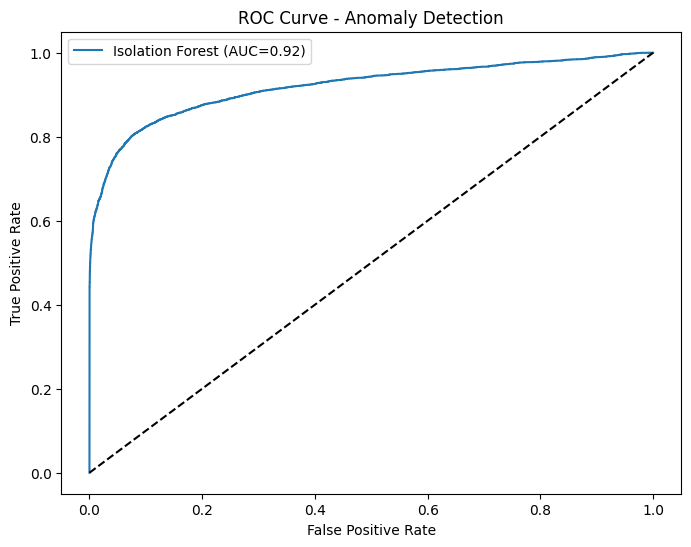

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from pyod.models.iforest import IForest
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score

# Config
PROCESSED_PATH = Path('../../data/processed')

# Chargement
print("Chargement des données...")
train = pd.read_csv(PROCESSED_PATH / 'train_FD001_features.csv')
test = pd.read_csv(PROCESSED_PATH / 'test_FD001_features.csv')

# Feature Selection (les capteurs les plus pertinents pour FD001)
# On prend les features 'mean' des capteurs sensisbles
features = [c for c in train.columns if 'mean' in c]
print(f"Nombre de features utilisées: {len(features)}")

# --- Création des Labels (Proxy) ---
# Hypothèse : RUL > 50 = Normal (0), RUL <= 50 = Anomalie (1)
train['label'] = (train['RUL'] <= 50).astype(int)
print(train['label'].value_counts())

# --- Split Train/Test pour l'Anomaly Detection ---
# Train : Uniquement des données SAINES (RUL > 50) pour apprendre la normalité
X_train_normal = train[train['label'] == 0][features]

# Test : Mélange de données saines et anormales pour évaluer
X_eval = train[features]
y_eval = train['label']

# --- Modélisation (Isolation Forest) ---
print("Entraînement Isolation Forest...")
clf = IForest(contamination=0.1, random_state=42)
clf.fit(X_train_normal)

# Prédiction sur tout le dataset (Train)
y_pred = clf.predict(X_eval)  # 0: Inliers, 1: Outliers
y_scores = clf.decision_function(X_eval)

# --- Évaluation ---
print("\n--- Rapport de Classification ---")
print(classification_report(y_eval, y_pred, target_names=['Normal', 'Anomalie']))

roc = roc_auc_score(y_eval, y_scores)
print(f"ROC-AUC Score: {roc:.4f}")

# Courbe ROC
fpr, tpr, _ = roc_curve(y_eval, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Isolation Forest (AUC={roc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Anomaly Detection')
plt.legend()
plt.show()